In [1]:
import torch
import numpy as np
from tqdm import tqdm
from data import Data
import onnx, onnxruntime ,onnxoptimizer
import intel_extension_for_pytorch as ipex
from torch.utils.data import DataLoader, random_split
from model import Convolutional_Neural_Network
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
dataset = Data("data")
train_len = int(np.round(dataset.len*0.8))
valid_len = int(np.round(dataset.len*0.1))
test_len = int(np.round(dataset.len*0.1))

train_data, valid_data, test_data = random_split(dataset = dataset, lengths = [train_len, valid_len, test_len], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_data, batch_size=16)
valid_loader = DataLoader(valid_data, batch_size=16)
test_loader = DataLoader(test_data, batch_size=1)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
CNN = Convolutional_Neural_Network().to(device)
learning_rate = CNN.get_learning_rate()
optimizer = torch.optim.Adam(CNN.parameters(), lr=learning_rate)
criterion = torch.nn.BCELoss()

In [5]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [6]:
train_loss_list = []
train_acc_list  =[]
valid_loss_list = []
valid_acc_list  =[]

for epoch in (range(CNN.get_epochs())):
    CNN.train()
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    for x_batch, y_batch in tqdm(train_loader, "Training"):
        optimizer.zero_grad()
        x_batch = x_batch.unsqueeze(0).permute(1,0,2).float()

        y_pred = CNN(x_batch.to(device))
        loss = criterion(y_pred.squeeze(-1), y_batch.to(device).float())
        acc = binary_acc(y_pred.squeeze(-1), y_batch.to(device).float())
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += acc.item()

    # check model's performance per epoch
    with torch.no_grad():
        CNN.eval()
        for x_val_batch, y_val_batch in tqdm(valid_loader, "Validation"):
            x_val_batch = x_val_batch.unsqueeze(0).permute(1,0,2).float()

            y_pred = CNN(x_val_batch.to(device))
            val_loss += criterion(y_pred.squeeze(-1), y_val_batch.to(device).float()).item()
            val_acc += binary_acc(y_pred.squeeze(-1), y_val_batch.to(device).float()).item()
    
    output = f'Epoch {epoch+1:03}: | Train loss: {train_loss/len(train_loader):.5f} | Train accuracy: {train_acc/len(train_loader):.3f}%'
    output += f' | Validation loss: {val_loss/len(valid_loader):.5f} | Validation accuracy: {val_acc/len(valid_loader):.3f}%'
    print(output)

Validation: 100%|██████████| 44/44 [00:00<00:00, 72.82it/s]


Epoch 001: | Train loss: 0.56198 | Train accuracy: 92.077% | Validation loss: 0.53717 | Validation accuracy: 98.773%


Validation: 100%|██████████| 44/44 [00:00<00:00, 86.45it/s]


Epoch 002: | Train loss: 0.52297 | Train accuracy: 97.763% | Validation loss: 0.52502 | Validation accuracy: 99.114%


Validation: 100%|██████████| 44/44 [00:00<00:00, 90.05it/s]


Epoch 003: | Train loss: 0.52036 | Train accuracy: 98.109% | Validation loss: 0.52494 | Validation accuracy: 97.955%


Validation: 100%|██████████| 44/44 [00:00<00:00, 88.49it/s]


Epoch 004: | Train loss: 0.51380 | Train accuracy: 98.703% | Validation loss: 0.52431 | Validation accuracy: 99.318%


Validation: 100%|██████████| 44/44 [00:00<00:00, 87.01it/s]


Epoch 005: | Train loss: 0.50901 | Train accuracy: 99.314% | Validation loss: 0.51850 | Validation accuracy: 99.455%


Validation: 100%|██████████| 44/44 [00:00<00:00, 90.26it/s]


Epoch 006: | Train loss: 0.50890 | Train accuracy: 99.243% | Validation loss: 0.50813 | Validation accuracy: 99.182%


Validation: 100%|██████████| 44/44 [00:00<00:00, 90.56it/s]


Epoch 007: | Train loss: 0.50822 | Train accuracy: 99.397% | Validation loss: 0.50538 | Validation accuracy: 100.000%


Validation: 100%|██████████| 44/44 [00:00<00:00, 89.97it/s]


Epoch 008: | Train loss: 0.50622 | Train accuracy: 99.520% | Validation loss: 0.50856 | Validation accuracy: 99.727%


Validation: 100%|██████████| 44/44 [00:00<00:00, 78.92it/s]


Epoch 009: | Train loss: 0.50709 | Train accuracy: 99.397% | Validation loss: 0.50811 | Validation accuracy: 99.864%


Validation: 100%|██████████| 44/44 [00:00<00:00, 85.77it/s]

Epoch 010: | Train loss: 0.50872 | Train accuracy: 99.260% | Validation loss: 0.51398 | Validation accuracy: 99.591%


In [7]:
CNN.eval()
y_pred_list = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:

        x_batch = x_batch.unsqueeze(0).permute(1,0,2).float()

        y_pred = CNN(x_batch.to(device))
        y_pred_tag = torch.round(y_pred.squeeze(-1))
        y_pred_list.append(int(y_pred_tag))

accuracy = (np.array(y_pred_list) == np.array(dataset.y)[test_data.indices]).sum() / len(y_pred_list) * 100
print('CNN accuracy: %.2f%%' % accuracy)

CNN accuracy: 99.14%


In [8]:
print(classification_report(np.array(y_pred_list), np.array(dataset.y)[test_data.indices]))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       520
           1       0.97      1.00      0.98       179

    accuracy                           0.99       699
   macro avg       0.98      0.99      0.99       699
weighted avg       0.99      0.99      0.99       699



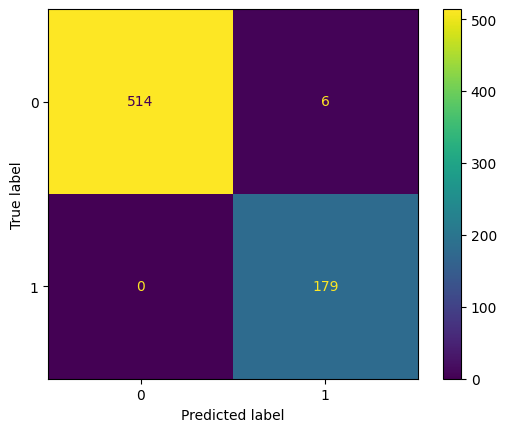

In [9]:
cm = confusion_matrix(np.array(y_pred_list), np.array(dataset.y)[test_data.indices])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [10]:
# torch.save(CNN, 'model_30_06_2024.pt')

In [11]:
# torch_input = torch.randn(16, 1, 8000, device=device)  # Example input size
# onnx_file_path = "mymodel.onnx"
# torch.onnx.export(CNN, torch_input, onnx_file_path, export_params=True, opset_version=12,
#                   do_constant_folding=True, input_names=['input'], output_names=['output'])

In [12]:
# model_onnx = onnx.load(onnx_file_path)
# onnx.checker.check_model(model_onnx)